# 추가 실험: Passband → Baseband Domain Shift (SF=9 고정)

이 노트북은 **베이스라인 특징 파이프라인은 그대로 유지**하면서,
passband에서 관측된 뒤 baseband로 내려오는 과정에서 생기는 **도메인 시프트(domain shift)**를 SOM 분포로 보여주는 실험 1개를 구성합니다.

파이프라인(동일):
- `dechirp → STFT(dB clip) → resize(64×32) → z-score → PCA(64) → SOM`

도메인 변수(최소 변경, 구현 쉬움):
- 랜덤 도착 지연 $\tau$ (delay)
- CFO $\Delta f$ (carrier frequency offset)


## 1) 도메인 정의(보고서/발표에 넣을 문장)

- Source domain $\mathcal{D}_S$: 동기화가 잘 된(clean) baseband 심볼
$$
\mathcal{D}_S = \{ x_b(t;\; SF=9,\; BW,\; f_c,\; \Delta f=0,\; \tau=0,\; h(t)=\delta(t),\; SNR=\infty ) \}
$$

- Target domain $\mathcal{D}_T$: passband에서 관측된 뒤 baseband로 내린(비이상) 심볼
$$
\mathcal{D}_T = \{ x_b(t;\; SF=9,\; BW,\; f_c,\; \Delta f\neq 0\ \text{or}\ \tau\neq 0\ \text{or}\ h(t)\neq\delta(t),\; SNR<\infty) \}
$$

- 목표: $\mathcal{D}_T$에서 관측된 입력을 $\mathcal{D}_S$의 정상 baseband 표현으로 복원/연상(BAM)

한 줄 요약: “도메인은 $(SF,BW,f_c)$와 $(\Delta f,\tau,h(t),SNR)$로 정의되며, passband→baseband 변환 과정에서 이 변수들이 특징 공간의 분포를 바꾼다.”

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings('ignore')

# 로컬 모듈 경로
sys.path.append('..')
sys.path.append('.')

from som import SelfOrganizingMap
from utils.LoRa import LoRa

from scipy.signal import stft
from scipy.ndimage import zoom
from sklearn.decomposition import PCA

# 기본 파라미터(베이스라인과 동일하게 유지)
SF_FIXED = 9
BW = 125e3
OSF = 1
FS = BW  # 기존 노트북 가정 유지 (Fs≈BW)

# SOM 토폴로지(베이스라인 유지: hex 추천)
TOPOLOGY = 'hex'
HEX_RADIUS = 1.0

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("Imports OK")

Imports OK


In [2]:
# 시각화 유틸: rect/hex 격자 모두 지원
def plot_som_background(ax, som, values, cmap='gray_r', alpha=0.35, vmin=None, vmax=None, edgecolor='k', linewidth=0.15):
    """SOM 배경(예: U-matrix)을 topology에 맞게 그려준다."""
    if getattr(som, 'topology', 'rect') == 'hex':
        centers = som.get_neuron_centers()  # (rows, cols, 2) -> [x,y]
        radius = float(getattr(som, 'hex_radius', 1.0))
        patches = []
        color_values = []
        rows, cols = values.shape
        for r in range(rows):
            for c in range(cols):
                x, y = centers[r, c]
                patches.append(RegularPolygon((x, y), numVertices=6, radius=radius, orientation=np.deg2rad(30)))
                color_values.append(float(values[r, c]))
        norm = Normalize(vmin=np.nanmin(values) if vmin is None else vmin, vmax=np.nanmax(values) if vmax is None else vmax)
        pc = PatchCollection(patches, cmap=cmap, norm=norm, edgecolor=edgecolor, linewidths=linewidth, alpha=alpha)
        pc.set_array(np.asarray(color_values))
        ax.add_collection(pc)
        ax.autoscale_view()
        ax.set_aspect('equal')
        ax.invert_yaxis()
        return pc
    else:
        im = ax.imshow(values, cmap=cmap, interpolation='nearest', alpha=alpha, vmin=vmin, vmax=vmax)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        return im

def bmu_positions_to_xy(som, bmu_positions, jitter=0.25, seed=0):
    """BMU (row,col) 배열을 scatter용 (x,y) 좌표로 변환."""
    rng = np.random.default_rng(seed)
    bmu_positions = np.asarray(bmu_positions)
    if getattr(som, 'topology', 'rect') == 'hex':
        centers = som.get_neuron_centers()
        radius = float(getattr(som, 'hex_radius', 1.0))
        jit = rng.uniform(-jitter, jitter, size=(len(bmu_positions), 2)) * radius
        xs = np.array([centers[r, c, 0] for r, c in bmu_positions]) + jit[:, 0]
        ys = np.array([centers[r, c, 1] for r, c in bmu_positions]) + jit[:, 1]
        return xs, ys
    else:
        jit = rng.uniform(-jitter, jitter, size=(len(bmu_positions), 2))
        xs = bmu_positions[:, 1] + jit[:, 0]
        ys = bmu_positions[:, 0] + jit[:, 1]
        return xs, ys

In [3]:
# 베이스라인 특징 추출 함수 (동일 파이프라인)
DB_CLIP = (-60, 0)
EPS = 1e-12

NPERSEG = 64
NOVERLAP = 32
NFFT = 256
F_BINS = 64
T_BINS = 32

USE_PCA = True
PCA_DIM = 64

MAP_SIZE_STFT = (24, 24)
SIGMA_STFT = max(MAP_SIZE_STFT) / 2
LR_STFT = 0.5
NUM_ITER_STFT = 15000

def stft_mag_vector(x, fs, nperseg, noverlap, nfft, f_bins, t_bins, db_clip=DB_CLIP, eps=EPS):
    """complex baseband 1D -> (fixed-size) STFT log-magnitude vector."""
    _, _, Zxx = stft(
        x, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap,
        nfft=nfft, return_onesided=False, boundary=None, padded=False,
    )
    S = np.abs(Zxx)
    S = np.fft.fftshift(S, axes=0)
    S_db = 20 * np.log10(S + eps)
    if db_clip is not None:
        S_db = np.clip(S_db, db_clip[0], db_clip[1])
    zf = f_bins / max(S_db.shape[0], 1)
    zt = t_bins / max(S_db.shape[1], 1)
    S_rs = zoom(S_db, (zf, zt), order=1)
    S_out = np.zeros((f_bins, t_bins), dtype=np.float32)
    ff = min(f_bins, S_rs.shape[0])
    tt = min(t_bins, S_rs.shape[1])
    S_out[:ff, :tt] = S_rs[:ff, :tt]
    v = S_out.reshape(-1).astype(np.float32)
    v = (v - v.mean()) / (v.std() + 1e-8)
    return v

In [4]:
# 도메인 변수(Delay, CFO)를 켠 Target domain 샘플 생성
DELAY_FRACS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]          # 6단계 (심볼 길이의 비율)
CFO_HZ_LIST = [0.0, 50.0, -50.0, 100.0, -100.0]      # 5단계 (Hz)  ※ 필요시 ±200Hz 추가
USE_DECHIRP = True                                    # 파이프라인 유지 (dechirp→STFT→...)

# 속도/디버그용: 너무 느리면 codeword 일부만 사용
MAX_CODEWORDS = None   # 예) 64 로 두면 64개 codeword만 사용 (빠른 확인용)

def apply_integer_delay_and_window(x, delay_samples, window_len):
    """지연을 주고, 고정 길이 window_len으로 자름(도착 시점 변화가 표현에 반영되게)."""
    d = int(delay_samples)
    if d <= 0:
        y = x
    else:
        y = np.concatenate([np.zeros(d, dtype=x.dtype), x])
    # 고정 길이로 윈도우 자르기 (delay가 크면 신호 일부가 잘릴 수 있음)
    if len(y) >= window_len:
        return y[:window_len]
    return np.pad(y, (0, window_len - len(y)))

def apply_cfo_baseband(x, cfo_hz, fs):
    """passband carrier mismatch를 baseband에서 CFO로 등가 모사: x(t) * exp(j2πΔf t)."""
    df = float(cfo_hz)
    if df == 0.0:
        return x
    n = np.arange(len(x), dtype=float)
    rot = np.exp(1j * 2 * np.pi * df * n / float(fs))
    return x * rot

# LoRa 심볼 생성기
l = LoRa(sf=SF_FIXED, bw=BW, OSF=OSF)
sym_len = 2 ** SF_FIXED
ref_down = l.gen_symbol(0, down=True) if USE_DECHIRP else None

print(f"SF_FIXED={SF_FIXED}, sym_len={sym_len}, BW={BW}, FS={FS}")
print(f"Delay bins: {DELAY_FRACS}")
print(f"CFO bins (Hz): {CFO_HZ_LIST}")

SF_FIXED=9, sym_len=512, BW=125000.0, FS=125000.0
Delay bins: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
CFO bins (Hz): [0.0, 50.0, -50.0, 100.0, -100.0]


In [5]:
# 데이터 구성: codeword 512개 × delay 6단계 × CFO 5단계 = 15,360개 (기본 설정)
X = []
y_codeword = []
y_delay_bin = []
y_cfo_bin = []

codes = np.arange(sym_len, dtype=int)
if MAX_CODEWORDS is not None:
    codes = codes[:int(MAX_CODEWORDS)]

for cw in codes:
    s_clean = l.gen_symbol(int(cw), down=False)
    for di, frac in enumerate(DELAY_FRACS):
        d_samp = int(round(float(frac) * sym_len))
        s_del = apply_integer_delay_and_window(s_clean, delay_samples=d_samp, window_len=sym_len)
        for ci, cfo_hz in enumerate(CFO_HZ_LIST):
            s_t = apply_cfo_baseband(s_del, cfo_hz=cfo_hz, fs=FS)
            if USE_DECHIRP:
                s_t = s_t * ref_down
            v = stft_mag_vector(
                s_t, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP, nfft=NFFT,
                f_bins=F_BINS, t_bins=T_BINS, db_clip=DB_CLIP, eps=EPS,
            )
            X.append(v)
            y_codeword.append(int(cw))
            y_delay_bin.append(int(di))
            y_cfo_bin.append(int(ci))

X = np.vstack(X).astype(np.float32)
y_codeword = np.asarray(y_codeword)
y_delay_bin = np.asarray(y_delay_bin)
y_cfo_bin = np.asarray(y_cfo_bin)

print(f"X shape: {X.shape}  (N={len(X)})")
print(f"Unique delay bins: {np.unique(y_delay_bin)}")
print(f"Unique CFO bins: {np.unique(y_cfo_bin)}")
print(f"Codeword count: {len(np.unique(y_codeword))}")

X shape: (15360, 2048)  (N=15360)
Unique delay bins: [0 1 2 3 4 5]
Unique CFO bins: [0 1 2 3 4]
Codeword count: 512


In [6]:
# PCA + SOM 학습 (파이프라인 유지)
if USE_PCA and PCA_DIM < X.shape[1]:
    pca = PCA(n_components=PCA_DIM, random_state=42)
    X_in = pca.fit_transform(X)
    print(f"PCA: {X.shape[1]} -> {X_in.shape[1]}")
    print(f"Explained variance ratio sum: {pca.explained_variance_ratio_.sum():.4f}")
else:
    X_in = X
    print("PCA skipped.")

som = SelfOrganizingMap(
    map_size=MAP_SIZE_STFT,
    input_dim=X_in.shape[1],
    sigma=SIGMA_STFT,
    learning_rate=LR_STFT,
    decay_function='exponential',
    topology=TOPOLOGY,
    hex_radius=HEX_RADIUS,
    random_seed=42,
)

print("SOM training...\n")
som.train(X_in, num_iterations=NUM_ITER_STFT, verbose=True)
print("\nDone.")

print(f"Quantization Error: {som.quantization_error(X_in):.4f}")
print(f"Topographic Error: {som.topographic_error(X_in):.4f}")

PCA: 2048 -> 64
Explained variance ratio sum: 0.9853
SOM training...

Iteration 1500/15000 - QE: 41.7009, TE: 0.1520, LR: 0.4524, σ: 9.2867
Iteration 3000/15000 - QE: 38.2795, TE: 0.2912, LR: 0.4094, σ: 7.1857
Iteration 4500/15000 - QE: 34.8150, TE: 0.0826, LR: 0.3704, σ: 5.5600
Iteration 6000/15000 - QE: 32.3077, TE: 0.0572, LR: 0.3352, σ: 4.3021
Iteration 7500/15000 - QE: 28.3008, TE: 0.0697, LR: 0.3033, σ: 3.3288
Iteration 9000/15000 - QE: 24.8772, TE: 0.0693, LR: 0.2744, σ: 2.5757
Iteration 10500/15000 - QE: 22.2950, TE: 0.0602, LR: 0.2483, σ: 1.9929
Iteration 12000/15000 - QE: 19.1441, TE: 0.0389, LR: 0.2247, σ: 1.5421
Iteration 13500/15000 - QE: 16.3652, TE: 0.0292, LR: 0.2033, σ: 1.1932
Iteration 15000/15000 - QE: 13.5517, TE: 0.0425, LR: 0.1840, σ: 0.9232

Done.
Quantization Error: 13.5517
Topographic Error: 0.0425


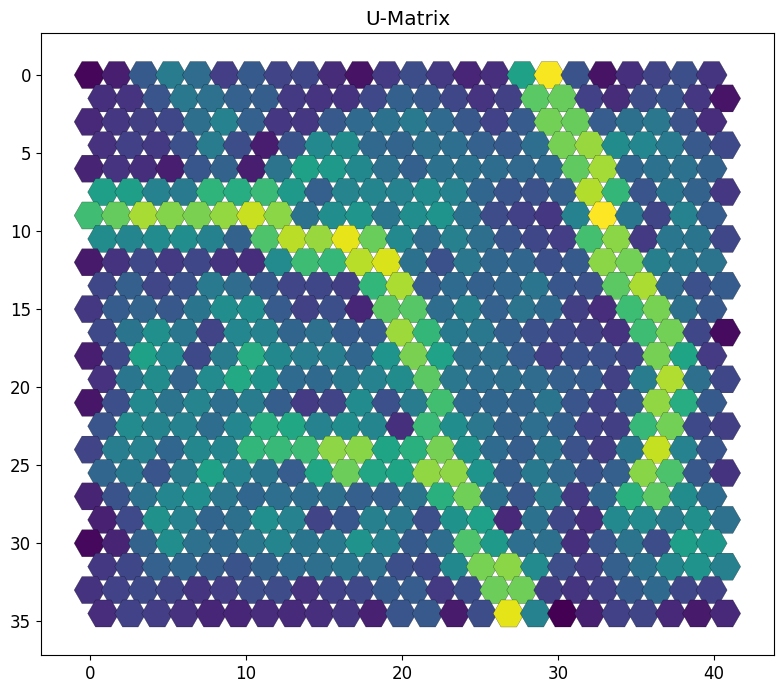

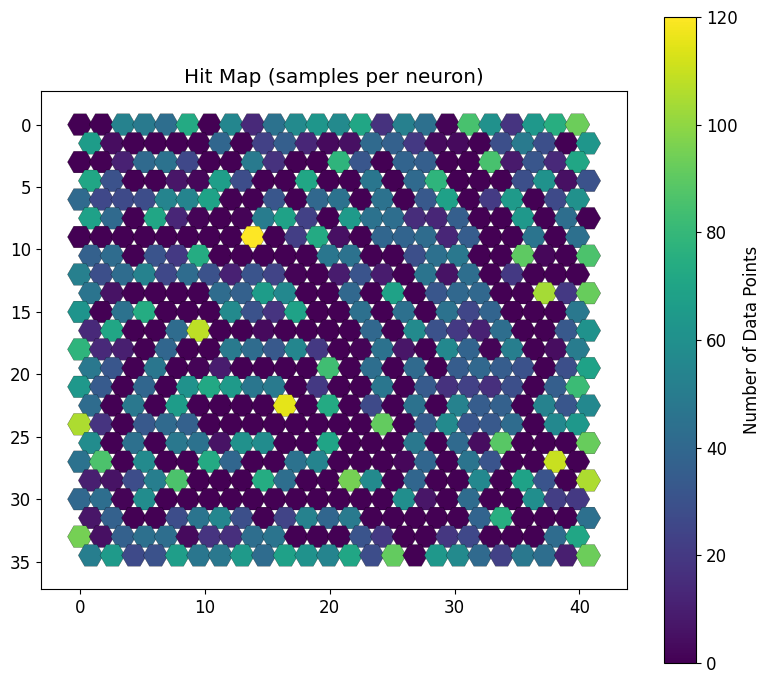

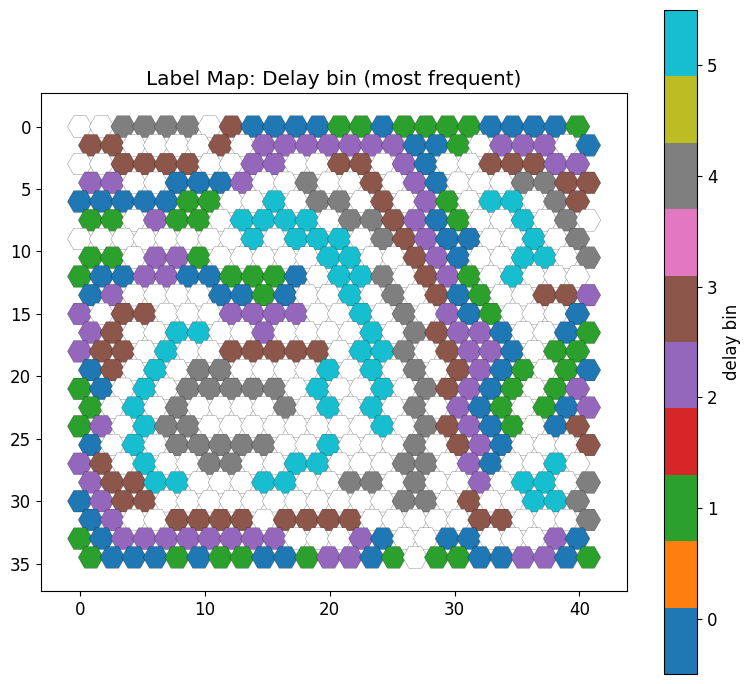

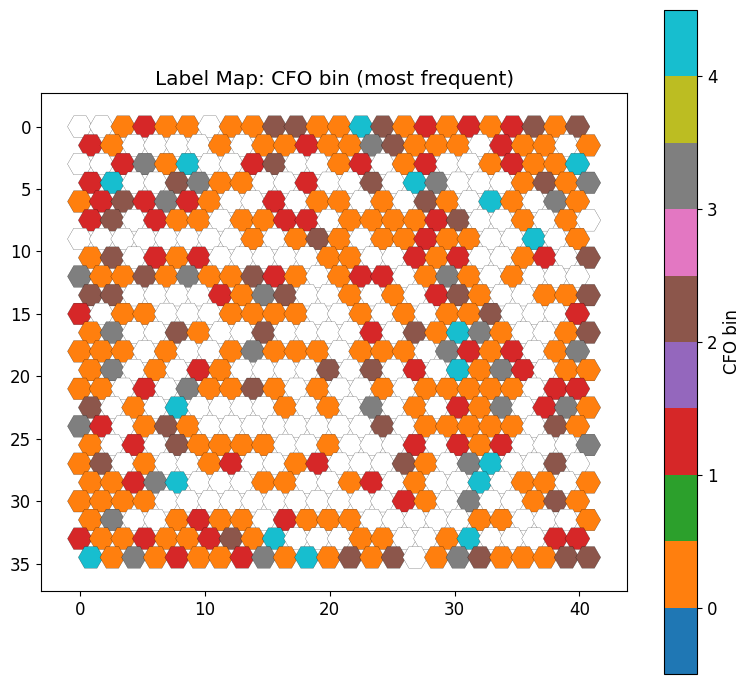

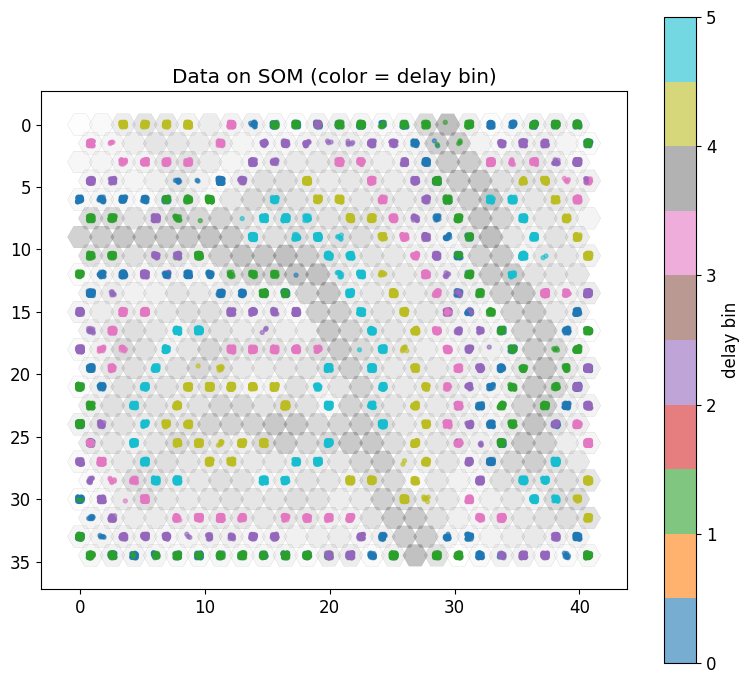

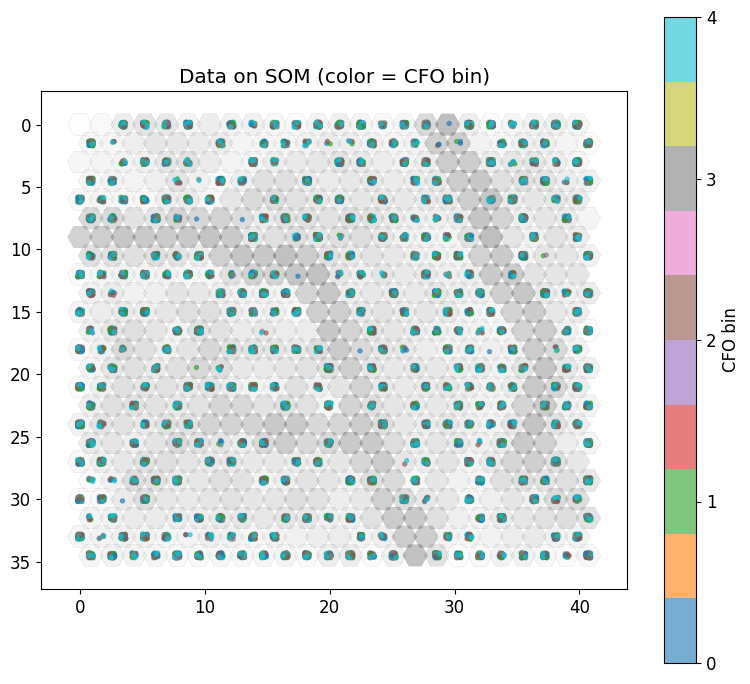

In [8]:

delay_labels = [f"τ={int(round(frac*100))}%" for frac in DELAY_FRACS]
cfo_labels = [f"Δf={int(v)}Hz" for v in CFO_HZ_LIST]

u = som.get_u_matrix()
rows, cols = som.map_size

# BMU를 한 번만(벡터화) 계산해서 모든 그림에 재사용 (plot_winner_map 중복 계산 방지)
def compute_bmu_positions_fast(X_data, som, batch_size=2048):
    X_data = np.asarray(X_data)
    W = som.weights.reshape(-1, X_data.shape[1]).astype(np.float32)  # (M, D)
    w2 = np.sum(W * W, axis=1).astype(np.float32)                   # (M,)
    N = X_data.shape[0]
    bmu_lin = np.empty(N, dtype=np.int32)
    WT = W.T  # (D, M)
    for s in range(0, N, batch_size):
        e = min(N, s + batch_size)
        Xb = X_data[s:e].astype(np.float32)
        x2 = np.sum(Xb * Xb, axis=1).astype(np.float32)[:, None]
        dots = Xb @ WT
        dist2 = x2 + w2[None, :] - 2.0 * dots
        bmu_lin[s:e] = np.argmin(dist2, axis=1).astype(np.int32)
    bmu_pos = np.column_stack([bmu_lin // cols, bmu_lin % cols]).astype(np.int32)
    return bmu_pos, bmu_lin

bmu_pos, bmu_lin = compute_bmu_positions_fast(X_in, som, batch_size=2048)

# 히트맵/라벨맵 만들기
hit = np.bincount(bmu_lin, minlength=rows * cols).reshape(rows, cols)

def majority_label_map(labels, n_labels):
    labels = np.asarray(labels, dtype=np.int32)
    out = np.full(rows * cols, np.nan, dtype=np.float32)
    for idx in range(rows * cols):
        mask = (bmu_lin == idx)
        if not np.any(mask):
            continue
        cnt = np.bincount(labels[mask], minlength=int(n_labels))
        out[idx] = float(np.argmax(cnt))
    return out.reshape(rows, cols)

delay_map = majority_label_map(y_delay_bin, n_labels=len(delay_labels))
cfo_map = majority_label_map(y_cfo_bin, n_labels=len(cfo_labels))

# 그림 1-A) U-matrix (빈 노드/가짜 경계 확인용)
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
plot_som_background(ax, som, u, cmap='viridis', alpha=1.0)
ax.set_title('U-Matrix')
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

# 그림 1-B) Hit map (samples per neuron)
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
pc = plot_som_background(ax, som, hit.astype(np.float32), cmap='viridis', alpha=1.0)
ax.set_title('Hit Map (samples per neuron)')
ax.set_xlabel('')
ax.set_ylabel('')
plt.colorbar(pc, ax=ax, label='Number of Data Points')
plt.tight_layout()
plt.show()

# Label map용 colormap (빈 노드=흰색)
tab10 = plt.get_cmap('tab10').copy()
tab10.set_bad((1, 1, 1, 1))

# 그림 2-A) Delay label map
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
pc = plot_som_background(ax, som, delay_map, cmap=tab10, alpha=1.0, vmin=-0.5, vmax=len(delay_labels)-0.5)
ax.set_title('Label Map: Delay bin (most frequent)')
ax.set_xlabel('')
ax.set_ylabel('')
plt.colorbar(pc, ax=ax, ticks=np.arange(len(delay_labels)), label='delay bin')
plt.tight_layout()
plt.show()

# 그림 2-B) CFO label map
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
pc = plot_som_background(ax, som, cfo_map, cmap=tab10, alpha=1.0, vmin=-0.5, vmax=len(cfo_labels)-0.5)
ax.set_title('Label Map: CFO bin (most frequent)')
ax.set_xlabel('')
ax.set_ylabel('')
plt.colorbar(pc, ax=ax, ticks=np.arange(len(cfo_labels)), label='CFO bin')
plt.tight_layout()
plt.show()

# 그림 2-C) Scatter colored by delay bin
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
plot_som_background(ax, som, u, cmap='gray_r', alpha=0.25)
xs, ys = bmu_positions_to_xy(som, bmu_pos, jitter=0.20, seed=1)
sc1 = ax.scatter(xs, ys, c=y_delay_bin, cmap='tab10', s=8, alpha=0.6)
ax.set_title('Data on SOM (color = delay bin)')
ax.set_xlabel('')
ax.set_ylabel('')
plt.colorbar(sc1, ax=ax, ticks=np.arange(len(delay_labels)), label='delay bin')
plt.tight_layout()
plt.show()

# 그림 2-D) Scatter colored by CFO bin
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
plot_som_background(ax, som, u, cmap='gray_r', alpha=0.25)
xs2, ys2 = bmu_positions_to_xy(som, bmu_pos, jitter=0.20, seed=2)
sc2 = ax.scatter(xs2, ys2, c=y_cfo_bin, cmap='tab10', s=8, alpha=0.6)
ax.set_title('Data on SOM (color = CFO bin)')
ax.set_xlabel('')
ax.set_ylabel('')
plt.colorbar(sc2, ax=ax, ticks=np.arange(len(cfo_labels)), label='CFO bin')
plt.tight_layout()
plt.show()